Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


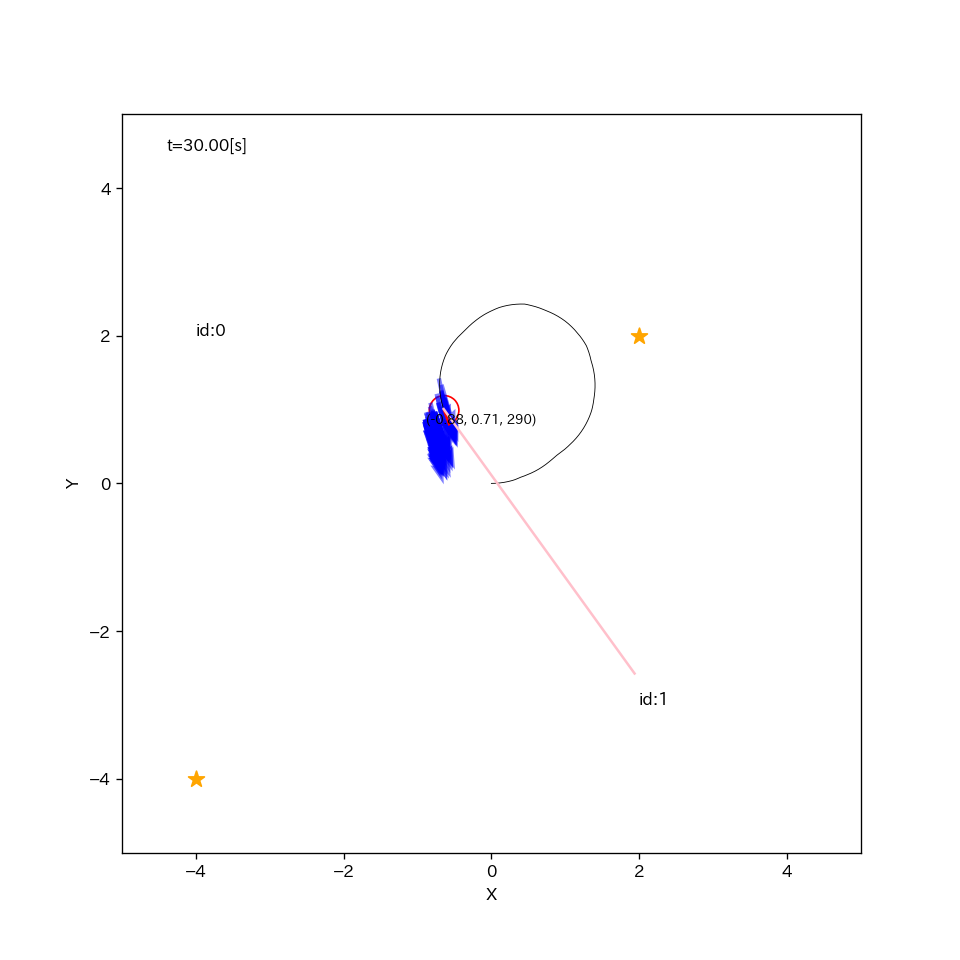

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [5]:
def trial(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

In [4]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            
    ok

0 真値: [ 0.22944737  0.27291949 15.41169661] 推定値: [ 0.21557558  0.03965058 15.35424819] 誤差: 0.23368100681174556
1 真値: [ 3.29792899  3.36256186 19.72039606] 推定値: [ 2.93158507  3.52686694 14.33640674] 誤差: 0.4015022079953311
2 真値: [ 3.44683032 -0.48461693 15.9195008 ] 推定値: [ 0.9080375  -5.25251812  0.14748565] 誤差: 5.401698885786259
3 真値: [-5.89597105 -2.18726606 18.73744653] 推定値: [-1.72150167  5.16359943 15.77288824] 誤差: 8.453485555648568
4 真値: [ 0.08178553 -0.24008115 18.93438392] 推定値: [ 0.06467963 -0.5920391  12.61257311] 誤差: 0.35237339406269796
5 真値: [-0.21858444 -4.9274653  15.33625605] 推定値: [-0.45570996 -4.44771878 15.11064806] 誤差: 0.5351497331979769
6 真値: [ 4.75596531  2.39557318 14.87412675] 推定値: [ 4.3990987   2.22633802 20.965836  ] 誤差: 0.3949611648973676
7 真値: [-0.28762497  1.32975822 23.85344626] 推定値: [-0.27762007  1.52856099 -1.28357682] 誤差: 0.19905436069358576
8 真値: [ 2.15450923 -3.46290979 20.14125424] 推定値: [ 2.10836035 -3.49393125 20.01645761] 誤差: 0.05560620495195531
9 真値: [-

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(8,8))


20 真値: [-1.17043938  1.00467606 21.36303583] 推定値: [-1.07411346  1.6014262  15.32117543] 誤差: 0.6044745002778381
21 真値: [-4.7665691   4.67492564 19.06488292] 推定値: [-2.72701823  4.44729058 12.09449855] 誤差: 2.0522147730961104
22 真値: [-4.23155822  3.15382357 18.40961353] 推定値: [-3.40722841  1.02875632  2.98860647] 誤差: 2.279348693696616
23 真値: [-0.25563729 -2.72066472 19.26902586] 推定値: [-0.51378191 -2.63541934 19.17763074] 誤差: 0.2718555129121404
24 真値: [ 2.64981733 -0.85587193 16.98452227] 推定値: [ 2.60082335 -1.10779214 17.0179844 ] 誤差: 0.25664021514245633
25 真値: [ 0.32105678 -0.18540609 20.06158203] 推定値: [ 0.46377366 -0.30159871 20.03319984] 誤差: 0.18403486736485414
26 真値: [ 6.32220282 -1.97328122 14.63245362] 推定値: [ 5.35950346 -2.23751688  9.52597557] 誤差: 0.9983038394260366
27 真値: [ 3.78572286 -1.2318889  18.21176405] 推定値: [ 4.06682409 -1.13446171 18.64900638] 誤差: 0.29750623012938565
28 真値: [-6.07912138  0.23569967 17.42197252] 推定値: [-4.79286375  5.39366825 15.60384056] 誤差: 5.315928756284585


In [2]:
print(ok)

NameError: name 'ok' is not defined